<a href="https://colab.research.google.com/github/lucas-azdias/Artistic-Text-Recognition/blob/main/artefatos/TCC%20-%20M%C3%A9todo%20Parseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações

In [1]:
!pip install -q pytorch-lightning lmdb --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 42.2 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import PIL
import sys
import torch
import torchvision
import tqdm

## Obtendo modelo

In [3]:
# URL do repositório
parseq_url = "https://github.com/baudm/parseq.git"
parseq_path = pathlib.Path("/content/parseq")

# Clonar o repositório
!rm -rf "{parseq_path}"
!git clone "{parseq_url}" "{parseq_path}"

if not str(parseq_path.absolute()) in sys.path:
    sys.path.append(str(parseq_path.absolute()))

Cloning into '/content/parseq'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (311/311), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 612 (delta 243), reused 193 (delta 193), pack-reused 301 (from 2)
Receiving objects: 100% (612/612), 1.34 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (344/344), done.


In [4]:
from parseq.hubconf import parseq as create_parseq

parseq = create_parseq(pretrained=True)
# parseq = torch.hub.load("baudm/parseq", "parseq", pretrained=True).eval()

/usr/local/lib/python3.12/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Downloading: "https://github.com/baudm/parseq/releases/download/v1.0.0/parseq-bb5792a6.pt" to /root/.cache/torch/hub/checkpoints/parseq-bb5792a6.pt


100%|██████████| 91.0M/91.0M [00:02<00:00, 34.7MB/s]


## Obtendo dataset

### Clonando dataset

In [5]:
# URL do repositório
dataset_url = "https://github.com/lucas-azdias/Artistic-Text-Recognition-Dataset.git"
dataset_path = pathlib.Path("/content/Artistic-Text-Recognition-Dataset")

# Clonar o repositório
!rm -rf "{dataset_path}"
!git clone "{dataset_url}" "{dataset_path}"

Cloning into '/content/Artistic-Text-Recognition-Dataset'...
remote: Enumerating objects: 12040, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 12040 (delta 4), reused 14 (delta 0), pack-reused 12010 (from 1)
Receiving objects: 100% (12040/12040), 1.29 GiB | 16.75 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (12005/12005), done.


### Carregando dataset

In [6]:
def load_data(base_path: pathlib.Path, name: str) -> tuple[list[pathlib.Path], list[str]]:
    labels_path = pathlib.Path(base_path, name, "labels.txt")

    image_paths = []
    classes = []

    with open(labels_path, "r") as f:
        for line in f:
            # Ex: "train_image\320.png Ford"
            splitted = line.strip().split(" ")
            path, label = splitted[0].replace("\\", "/"), " ".join(splitted[1:])

            # Ajustar o caminho para apontar para a pasta correta
            img_path = pathlib.Path(base_path, name, pathlib.Path(path))
            image_paths.append(img_path)
            classes.append(label)

    return image_paths, classes

train_images, train_labels = load_data(dataset_path, "train")
testA_images, testA_labels = load_data(dataset_path, "testA")
testB_images, testB_labels = load_data(dataset_path, "testB")

### Ajustando dataset para formato PyTorch

In [7]:
class ArtisticTextDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img, label = self.get_raw(idx)
        if self.transform:
            img = self.transform(img)
        return img, label

    def get_raw(self, idx):
        img = PIL.Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        return img, label

In [8]:
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(parseq.hparams.img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Criar datasets
train_dataset = ArtisticTextDataset(train_images, train_labels, transform=img_transform)
testA_dataset = ArtisticTextDataset(testA_images, testA_labels, transform=img_transform)
testB_dataset = ArtisticTextDataset(testB_images, testB_labels, transform=img_transform)

# Criar dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
testA_dataloader = torch.utils.data.DataLoader(testA_dataset, batch_size=16, shuffle=False)
testB_dataloader = torch.utils.data.DataLoader(testB_dataset, batch_size=16, shuffle=False)

### ~Criando versão LMDB do dataset~

In [9]:
# lmdb_dataset_path = "/content/data"
# !python "{dataset_path}/utils/create_lmdb_dataset.py" "{dataset_path}/train" "{dataset_path}/train/labels.txt" "{lmdb_dataset_path}/train/real" --checkValid=True

# Execução

## Exemplo de predição

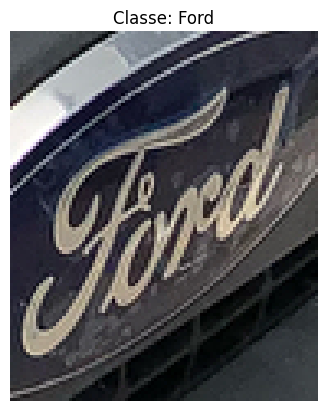

In [9]:
img, label = ArtisticTextDataset(train_images, train_labels)[0]
plt.imshow(img)
plt.title(f"Classe: {label}")
plt.axis("off")
plt.show()

In [10]:
img, label = train_dataset[0]

img = img.unsqueeze(0)

logits = parseq(img)
print(logits.shape)  # torch.Size([1, 26, 95]), 94 caracteres + símbolo [EOS]

pred = logits.softmax(-1)
pred_label, pred_confidence = parseq.tokenizer.decode(pred)
pred_confidence = [f"{100 * c:.2f}%" for c in pred_confidence[0].tolist()]

# Confiança para cada letra + [EOS]
print(f"Predicted \"{label}\" as \"{pred_label[0]}\" ({', '.join(pred_confidence)})")

torch.Size([1, 26, 95])
Predicted "Ford" as "Ford" (98.58%, 99.91%, 99.92%, 99.95%, 99.73%)


## Teste inicial do modelo

In [11]:
trues = []
preds = []
confs = []

for imgs, labels in tqdm.tqdm(testA_dataloader, desc="Testing"):
    # Predição do modelo
    logits = parseq(imgs)
    pred_labels, pred_confidences = parseq.tokenizer.decode(logits.softmax(-1))

    for label, pred_label, pred_confidence in zip(labels, pred_labels, pred_confidences):
        # Confiança formatada
        pred_confidence_fmt = [f"{c * 100:.2f}%" for c in pred_confidence.tolist()]

        # Armazena o resultado
        trues.append(label)
        preds.append(pred_label)
        confs.append(pred_confidence_fmt)

Testing: 100%|██████████| 188/188 [03:52<00:00,  1.24s/it]


In [12]:
preds = np.array(preds)
trues = np.array(trues)

corrects = preds == trues

correct = np.sum(corrects)
total = len(testA_dataset)
print(f"Acurácia: {(correct / total) * 100:.2f}% ({correct}/{total})")

Acurácia: 78.17% (2345/3000)


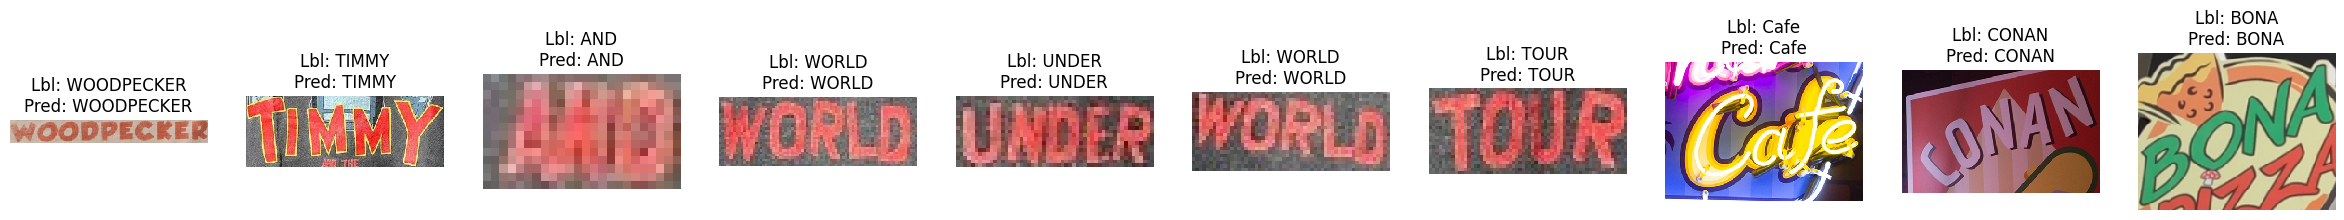

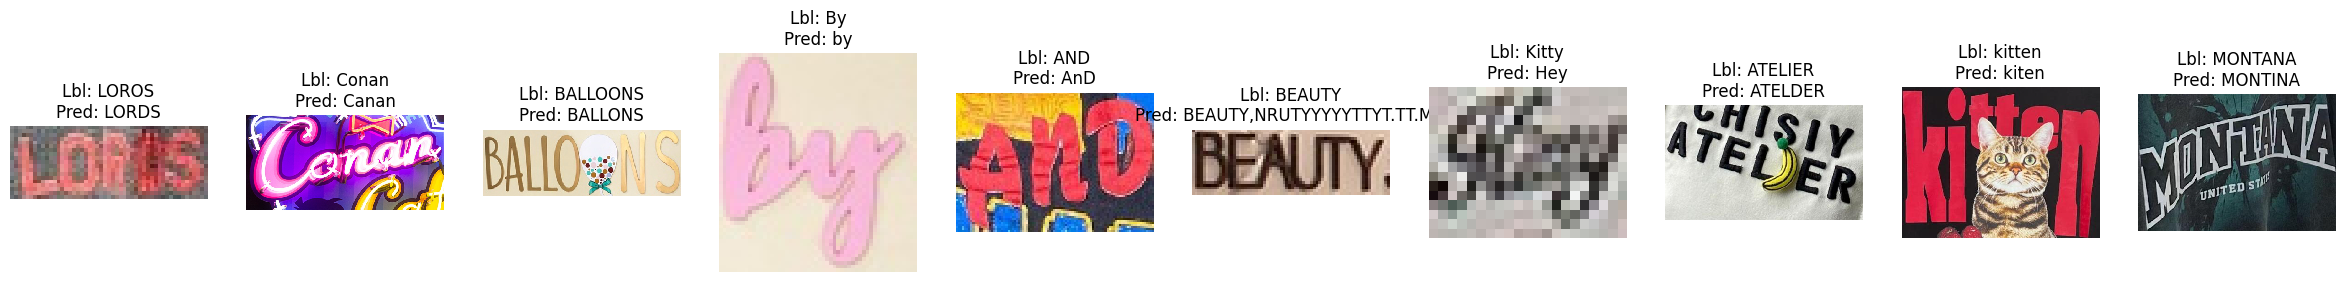

In [16]:
index = np.random.randint(total)
amount = 10

masks = [np.where(corrects)[0], np.where(~corrects)[0]]

for mask in masks:
    valid_indices = mask[mask >= index][:amount]

    _, axes = plt.subplots(nrows=1, ncols=len(valid_indices), figsize=(30, 12))

    if len(valid_indices) == 1:
        axes = [axes]

    for ax, idx in zip(axes, valid_indices):
        img, _ = testA_dataset.get_raw(idx)
        ax.set_axis_off()
        ax.imshow(img, cmap="gray_r", interpolation="nearest")
        ax.set_title(f"Lbl: {trues[idx]}\nPred: {preds[idx]}")

plt.show()

# ~Fine-tuning do modelo~

In [14]:
# !sed -i "s/local_dir=/storage_path=/g" "{parseq_path}/tune.py" # Ajusta "local_dir" para "storage_path" por incompatibilidade de versões do "ray"
# !python "{parseq_path}/tune.py" data.root_dir="data" data.train_dir="real"

In [13]:
# !python "{parseq_path}/tune.py" --help

In [23]:
# Fine-tune para o dataset
# Dicionário com estratégia